In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from torchsummary import summary

In [2]:
class WinCondition:
    def __init__(self):
        self.win_player = "X"

    def check_win(self):
        layers = self.check_all_layers()
        z_check = self.check_all_z()
        diag = self.check_cross_diagonals() or self.check_all_vertical_diagonals()

        return diag or z_check or layers

    def check_all_layers(self):
        return any(self.check_layer(z) for z in range(4))

    def check_all_z(self):
        return any(self.check_z(x, y) for x in range(4) for y in range(4))

    def check_all_vertical_diagonals(self):

        xdiag = any(self.check_vertical_xdiagonals(x) for x in range(4))
        ydiag = any(self.check_vertical_ydiagonals(y) for y in range(4))

        return xdiag or ydiag

    def check_layer(self, z):
        x_checker = any(self.check_x(y, z) for y in range(4))
        y_checker = any(self.check_y(x, z) for x in range(4))
        diag_checker = self.check_diagonals(z)

        return x_checker or y_checker or diag_checker

    def check_cross_diagonals(self):
        first = all(self.board[c][c][c] == self.win_player for c in range(4))
        second = all(self.board[c][3-c][3-c] == self.win_player for c in range(4))
        third = all(self.board[c][c][3-c] == self.win_player for c in range(4))
        fourth = all(self.board[c][3-c][c] == self.win_player for c in range(4))

        return first or second or third or fourth

    def check_x(self, y, z):
        return all(self.board[x][y][z] == self.win_player for x in range(4))


    def check_y(self, x, z):
        return all(self.board[x][y][z] == self.win_player for y in range(4))

    def check_diagonals(self, z):
        if all(self.board[diag][diag][z] == self.win_player for diag in range(4)):
            return True

        if all(self.board[3-reverse_diag][reverse_diag][z] == self.win_player for reverse_diag in range(4)):
            return True

        return False

    def check_z(self, x, y):
        return all(self.board[x][y][z] == self.win_player for z in range(4))

    def check_vertical_xdiagonals(self, x):
        if all(self.board[x][diag][diag] == self.win_player for diag in range(4)):
            return True

        if all(self.board[x][reverse_diag][3-reverse_diag] == self.win_player for reverse_diag in range(4)):
            return True

        return False

    def check_vertical_ydiagonals(self, y):
        if all(self.board[diag][y][diag] == self.win_player for diag in range(4)):
            return True

        if all(self.board[reverse_diag][y][3-reverse_diag] == self.win_player for reverse_diag in range(4)):
            return True

        return False

In [3]:
class TicTacToe4x4x4(WinCondition):
    def __init__(self, render_mode="computer"):
        # 3D board: 4 layers of 4x4 grids
        super().__init__()
        self.board = [[[" " for _ in range(4)] for _ in range(4)] for _ in range(4)]
        self.current_player = "X"
        self.players = ["X", "O"]
        self.terminated = False
        self.winner = " "
        self.render_mode = render_mode

    def check_draw(self):
        # Check for any empty space in the entire 3D board
        return not any(
            " " in self.board[x][y][z] for x in range(4) for y in range(4) for z in range(4)
        )

    def get_action_space(self):
        action_space = []
        for x in range(4):
            for y in range(4):
                for z in range(4):
                    if self.board[x][y][z] == " ":
                        action_space.append(self.get_position(x, y, z))

        action_space.sort()
        return action_space

    def print_board(self):
        # Prints each layer of the 3D board
        for layer in range(4):
            print(f"Layer {layer + 1}:")
            print("┌───┬───┬───┬───┐")
            for i, row in enumerate(self.board[layer]):
                print("│ " + " │ ".join(row) + " │")
                if i < 3:
                    print("├───┼───┼───┼───┤")
            print("└───┴───┴───┴───┘")
            if layer < 3:
                print()

    def create_visualization(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        for x in range(4):
            for y in range(4):
                for z in range(4):
                    if self.board[x][y][z] == "X":
                        ax.scatter(x, y, z, color="r", marker="o")
                    if self.board[x][y][z] == "O":
                        ax.scatter(x, y, z, color="b", marker="o")

        cmin = 0
        cmax = 3

        ax.set_xticks(np.arange(cmin, cmax + 1, 1))
        ax.set_yticks(np.arange(cmin, cmax + 1, 1))
        ax.set_zticks(np.arange(cmin, cmax + 1, 1))

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        if self.winner != " ":
            plt.title(f"Player {self.winner} Won!")
        else:
            plt.title(f"Player {self.current_player} Turn" )

        plt.show()

    def change_player(self):
        if self.current_player == "X":
            self.current_player = "O"
        else:
            self.current_player = "X"

    def get_coordinates(self, position):
        x = int((position % 16) % 4)
        y = int((position % 16) / 4)
        z = int(position / 16)

        return x, y, z

    def get_position(self, x, y, z):
        return z * 16 + y * 4 + x

    def update_board(self, x, y, z):
        reward = 0

        if self.terminated:
            return self.board, reward, self.terminated, self.current_player

        if self.board[x][y][z] == " ":
            self.board[x][y][z] = self.current_player
        else:
            self.terminated = True
            return self.board, reward, self.terminated, self.current_player


        self.win_player = self.current_player
        win = self.check_win()
        draw = self.check_draw()

        self.terminated = win or draw

        if win:
            if self.current_player == "X":
                reward = -1
                self.winner = "X"
            else:
                reward = 1
                self.winner = "O"
        elif draw:
            reward = 0

        self.change_player()

        return self.board, reward, self.terminated, self.current_player

    def step_coordinates(self, x, y, z):
        # Output: Observation, reward, terminated, player_turn
        observation, reward, terminated, player_turn = self.update_board(x, y, z)

        if self.render_mode == "human":
            self.create_visualization()

        return observation, reward, terminated, player_turn

    def step(self, position):

        # Output: Observation, reward, terminated, player_turn
        x, y, z = self.get_coordinates(position)
        observation, reward, terminated, player_turn = self.update_board(x, y, z)

        # if self.render_mode == "human":
        #     self.create_visualization()

        return observation, reward, terminated, player_turn

In [4]:
# Helper function to convert observation to an input tensor for NN
def observation_to_tensor(observation):
    char_to_num = {'X': -1, 'O': 1, ' ': 0}
    array = np.array([[[char_to_num[char] for char in row] for row in array] for array in observation]).flatten(order='F')
    return torch.tensor(array)

# Helper function for action selection using epsilon greedy
def epsilon_greedy(Q, current_player, epsilon, action_space):
    rand = random.uniform(0, 1)
    if rand > epsilon:
        if current_player == "X":
            action = np.argmin(Q)
        elif current_player == "O":
            action = np.argmax(Q)
    else:
        action = random.choice(action_space)

    return action

# Helper function to mask out invalid actions for a given state
def mask(Q, action_space):
    mask = np.zeros_like(Q, dtype=bool)
    mask[action_space] = True
    Q[~mask] = 0

    return Q

In [5]:
class DNN(nn.Module):
    def __init__(self, in_features=64, h1=304, h2=32, out_features=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, out_features),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
NN = DNN().to(device)

# Now, you can use the standard PyTorch summary
summary(NN, (1, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 304]          19,760
              ReLU-2               [-1, 1, 304]               0
            Linear-3                [-1, 1, 32]           9,760
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 64]           2,112
              Tanh-6                [-1, 1, 64]               0
Total params: 31,632
Trainable params: 31,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [6]:
r_prev_1 = 0
r_prev_2 = 0

N = 1

for i in range(N):
    env = TicTacToe4x4x4()
    terminated = 0
    terminated_1 = 0
    terminated_2 = 0
    s_1 = [[[" " for _ in range(4)] for _ in range(4)] for _ in range(4)]
    reward = 0
    player_turn = "X"

    s_prev_1, a_prev_1 = 0, 0
    s_prev_2, a_prev_2 = 0, 0

    epsilon = 0.1
    gamma = 1.0

    for j in range(64):
        if player_turn == "X":
            if not terminated_2:
                action_space = env.get_action_space()
                s_1_tensor = observation_to_tensor(s_1)
                Q_1 = NN(s_1_tensor.float().to(device)).detach().cpu().numpy()

                Q_1 = mask(Q_1, action_space)
                a_1 = epsilon_greedy(Q_1, player_turn, epsilon, action_space)

                if j == 0:
                    s_prev_1, a_prev_1 = s_1_tensor, a_1
                    s_2, r_1, terminated, player_turn = env.step(a_1)
                    r_prev_1 = r_1
                    continue
                else:
                    Q_new_prev_1 = r_prev_1 + gamma * min(Q_1)
                    Q_prev_1 = NN(s_prev_1.float().to(device)).detach().cpu().numpy()

                    error = Q_new_prev_1 - Q_prev_1[a_prev_1]

                    # Back propagate here

                    if not terminated_1:
                        s_prev_1, a_prev_1 = s_1_tensor, a_1
                        s_2, r_1, terminated_1, player_turn = env.step(a_1)
                        r_prev_1 = r_1
                        continue
                    else:
                        break
        else:
            if not terminated_1:
                action_space = env.get_action_space()
                s_2_tensor = observation_to_tensor(s_2)
                Q_2 = NN(s_2_tensor.float().to(device)).detach().cpu().numpy()

                Q_2 = mask(Q_2, action_space)
                a_2 = epsilon_greedy(Q_2, player_turn, epsilon, action_space)

                if j == 1:
                    s_prev_2, a_prev_2 = s_2_tensor, a_2
                    s_1, r_2, terminated, player_turn = env.step(a_2)
                    r_prev_2 = r_2
                    continue
                else:
                    Q_new_prev_2 = r_prev_2 + gamma * max(Q_1)
                    Q_prev_2 = NN(s_prev_2.float().to(device)).detach().cpu().numpy()

                    error = Q_new_prev_2 - Q_prev_2[a_prev_2]

                    # Back propagate here

                    if not terminated_2:
                        s_prev_2, a_prev_2 = s_2_tensor, a_2
                        s_1, r_2, terminated_2, player_turn = env.step(a_2)
                        r_prev_2 = r_2
                    else:
                        break

In [8]:
# Initialized as a random policy for player 1
def policy_player1(observation, action_space):
    position = random.choice(action_space)

    #check for possibility of player "X" winning
    possible_actions = []
    temp_board = copy.deepcopy(observation)
    for a in action_space:
      env1 = TicTacToe4x4x4(render_mode="human")
      env1.board = copy.deepcopy(temp_board)
      env1.current_player = 'X'
      observation, reward, terminated, player_turn = env1.step(a)
      win  = env1.check_win()
      if win:
        possible_actions.append(a)

    #If there is a move that would win the game, do the first one that does.
    if (len(possible_actions) > 0):
        position = possible_actions[0]

    #Otherwise, if the opponent has any way to win next turn, block the first one found.
    else:
      possible_actions_1 = []
      for a in action_space:
        env1 = TicTacToe4x4x4(render_mode="human")
        env1.board = copy.deepcopy(temp_board)
        env1.current_player = 'O'
        observation, reward, terminated, player_turn = env1.step(a)
        win  = env1.check_win()
        if win:
          possible_actions_1.append(a)

      if(len(possible_actions_1)> 0):
        position = possible_actions_1[0]

    return position

# Initialized as a random policy for player 2
def policy_player2(observation, action_space):
    position = random.choice(action_space)

    return position

In [12]:
def play_one_game(policy_player1, policy_player2, render_mode="computer"):
    env = TicTacToe4x4x4(render_mode)

    terminated = 0
    observation = [[[" " for _ in range(4)] for _ in range(4)] for _ in range(4)]
    reward = 0
    player_turn = "X"
    win = False
    draw = False

    while not terminated:

        action_space = env.get_action_space()

        if player_turn == "X":
            action = policy_player1(observation, action_space)

        else:
            action = policy_player2(observation, action_space)


        observation, reward, terminated, player_turn = env.step(action)

    return reward # This is the player who won

Testing our Policy against random Policy

In [13]:
p1 = 0
p2 = 0
draw = 0

for i in range(100):
  out = play_one_game(policy_player1, policy_player2)
  if out == 0:
    draw +=1
  elif out == -1:
    p1 += 1
  elif out == 1:
    p2 +=1

In [14]:
print("Draws = " , draw)
print("Player 1 wins = ", p1)
print("Player 2 wins = ", p2)

Draws =  0
Player 1 wins =  100
Player 2 wins =  0


Checking our Policy against Human

Enter x: 0
Enter y: 0
Enter z: 0


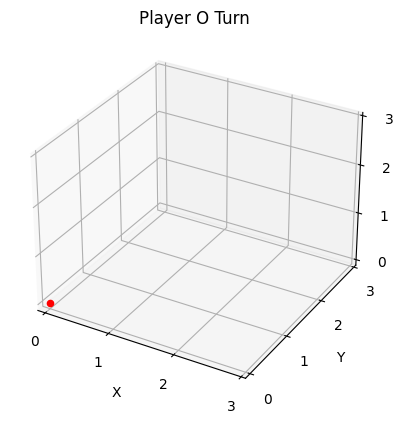

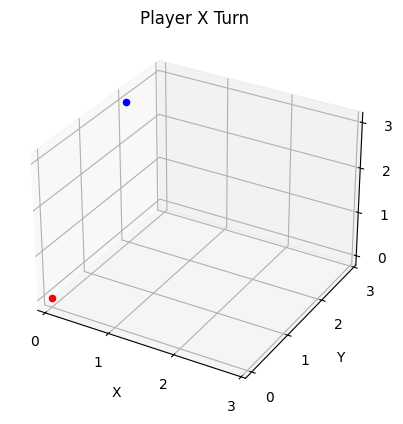

Enter x: 1
Enter y: 0
Enter z: 0


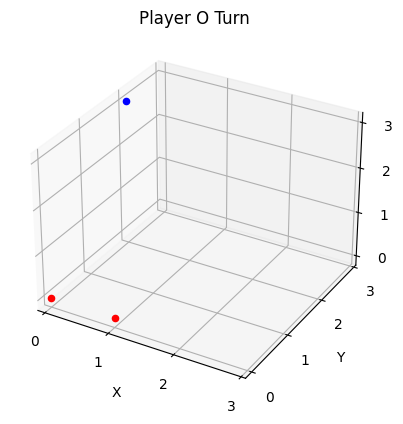

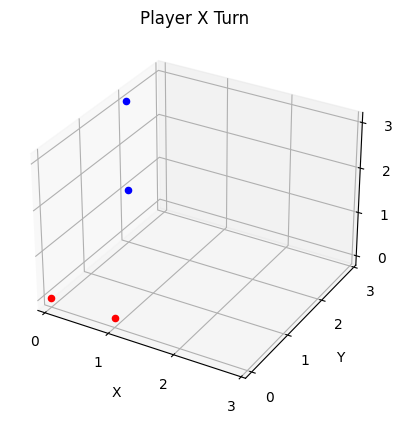

Enter x: 2
Enter y: 0
Enter z: 0


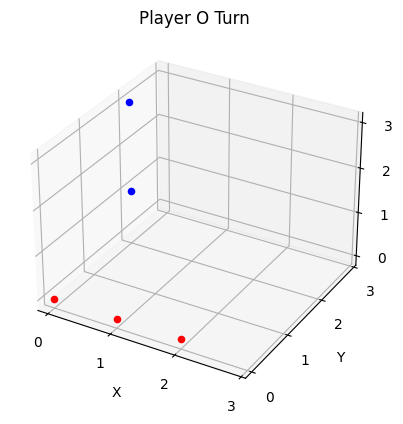

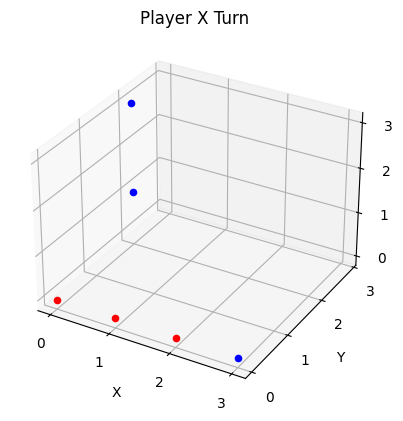

Enter x: 0
Enter y: 2
Enter z: 2


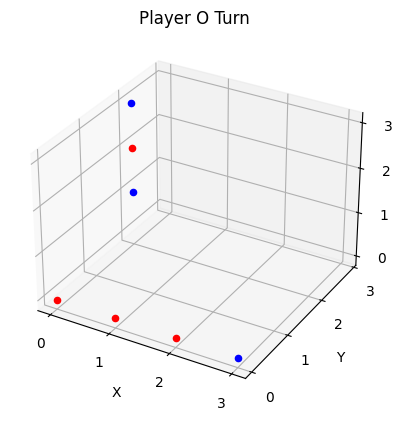

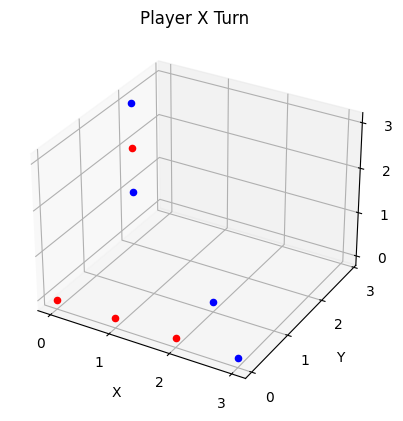

Enter x: 1
Enter y: 1
Enter z: 1


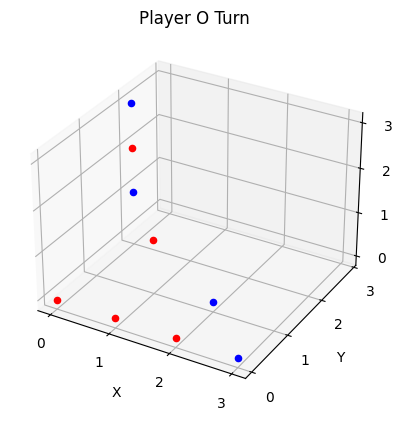

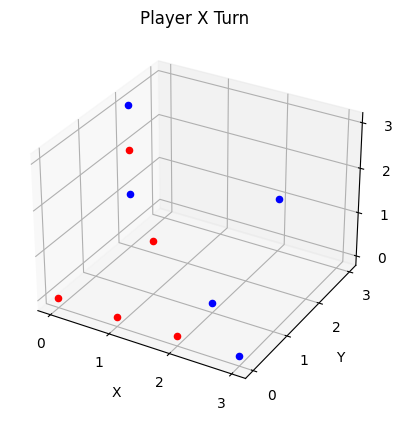

Enter x: 0
Enter y: 1
Enter z: 0


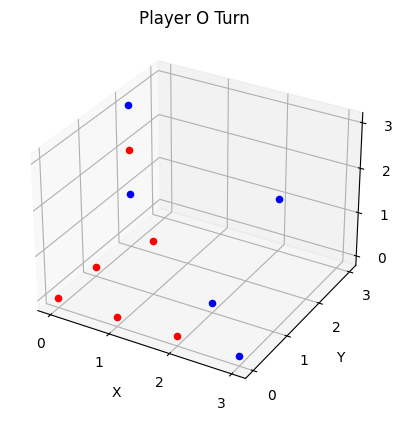

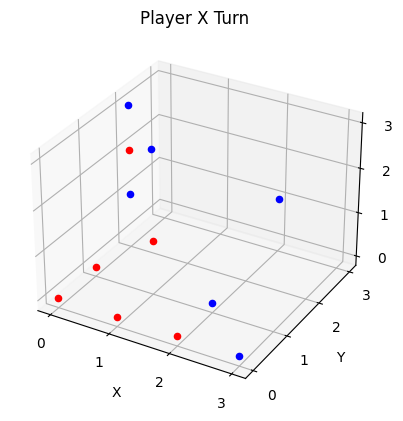

Enter x: 0
Enter y: 2
Enter z: 0


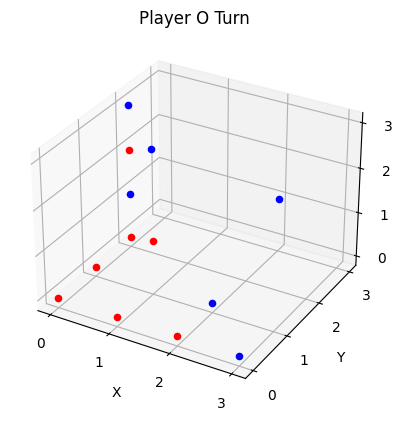

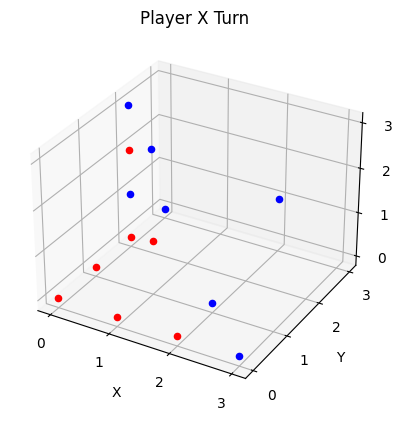

Enter x: 3
Enter y: 1
Enter z: 1


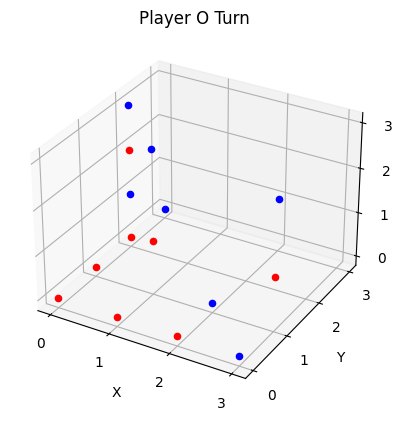

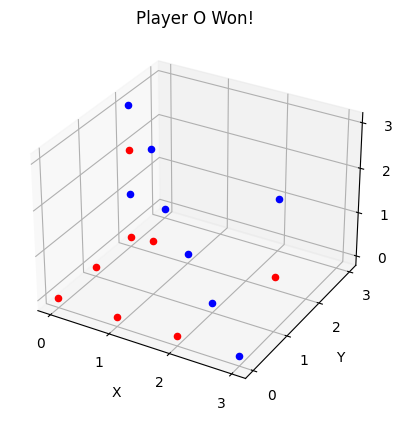

In [697]:
env = TicTacToe4x4x4(render_mode="computer")

terminated = 0
observation = [[[" " for _ in range(4)] for _ in range(4)] for _ in range(4)]
reward = 0
player_turn = "X"

while not terminated:

    action_space = env.get_action_space()

    if player_turn == "X":
        user_input = int(input("Enter x: "))
        user_input1 = int(input("Enter y: "))
        user_input2 = int(input("Enter z: "))
        action = env.get_position(user_input,user_input1,user_input2)

    else:
        action = policy_player1(observation, action_space)


    observation, reward, terminated, player_turn = env.step(action)

    env.create_visualization()
